# Afternoon Activity - Day 9

#### This notebook was developed by [Zeljko Ivezic](http://faculty.washington.edu/ivezic/) for the 2021 data science class at the University of Sao Paulo and it is available from [github](https://github.com/ivezic/SaoPaulo2021/blob/main/notebooks/Activity9.ipynb).

## Problem 1: clustering of orbital data for asteroids

Asteroids are clustered in orbital parameter space (6 dimensions
but here we will consider two: semi-major axis and inclination)
and these clusters, known as families, are believed to be remnants of larger asteroids destroyed in collisions. Typically, families have
uniform colors, for more details see [Parker et al. 2008.](
http://faculty.washington.edu/ivezic/Publications/parker.pdf)

Using the Parker et al. dataset, available from astroML, apply 
Gaussian Mixture Model and the Minimum Spanning Tree model and
compare their clustering results.



## Problem 2: supervised classification of periodic variable stars in 4-D space of colors and lightcurve parameters

Let's apply a number of classification methods to 4-D data for periodic variable stars from the SDSS and LINEAR surveys:

-- SDSS u-g and g-i colors,

-- LINEAR variability period (logP) and variability amplitude (A).

We also have labels (light curve type 
[determined by domain experts](http://faculty.washington.edu/ivezic/Publications/Palaversa2013LINEAR.pdf)
and thus we are **implementing supervised classification**. 

The question we are asking in this exercise is: "How well can we separate RR Lyrae stars from other periodic variable stars using this 4-D information?"

This is the same data sample as in Problem 2 from Afternoon Activity - Day 7 and Problem 3 from Afternoon Activity - Day 8. 

In [1]:
%matplotlib inline
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture as GMM
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
from astroML.datasets import fetch_moving_objects
from astroML.plotting.tools import draw_ellipse
from astroML.clustering import HierarchicalClustering, get_graph_segments
setup_text_plots(fontsize=8, usetex=True)
# random seed 
np.random.seed(42)

## Problem 1: clustering with Gaussian Mixture Model and the Minimum Spanning Tree model for asteroids

### For completeness, we expect structure like this:

![Parker et al. asteroid families](http://faculty.washington.edu/ivezic/sdssmoc/MOC4_population_labels.jpg) 

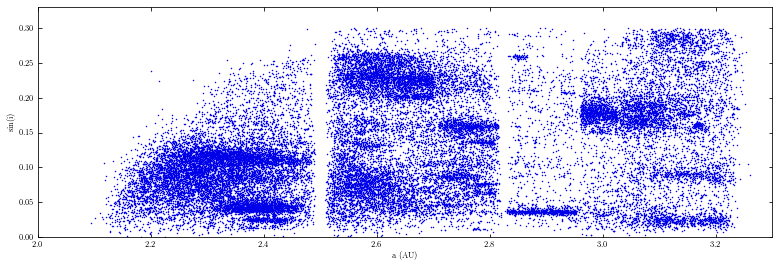

In [2]:
# Fetch data and extract the desired quantities
dataAll = fetch_moving_objects(Parker2008_cuts=True)
data = dataAll[1:]
a = data['aprime']
sini = data['sin_iprime']
acolor = data['mag_a']
izcolor = data['mag_i'] - data['mag_z']
X = np.vstack([a, sini]).T

#------------------------------------------------------------
# Plot 
xmin, xmax = (2.0, 3.3)
ymin, ymax = (0.0, 0.33)
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(311)
ax.scatter(X[:, 0], X[:, 1], s=1, lw=0.5, c='k')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('a (AU)')
ax.set_ylabel('sin(i)')

plt.show()

In [3]:
#------------------------------------------------------------
# Compute GMM models & AIC/BIC
N = np.arange(1, 60)
def compute_GMM(N, covariance_type='full', max_iter=100):
    models = [None for n in N]
    for i in range(len(N)):
        models[i] = GMM(n_components=N[i], max_iter=max_iter,
                        covariance_type=covariance_type)
        models[i].fit(X)
    return models

models = compute_GMM(N)
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]
i_best = np.argmin(BIC)
gmm_best = models[i_best]

print("best fit converged:", gmm_best.converged_)
print("BIC: n_components =  %i" % N[i_best])

best fit converged: True
BIC: n_components =  32


0 18 0.05461760823952191
1 22 0.05030369209296003
2 21 0.048130489584071866
3 12 0.04540940544259136
4 5 0.044741481304254815
5 13 0.04353010911307614
6 14 0.042666102956927646
7 7 0.042557218147197845
8 0 0.04242489412603562
9 15 0.038939479401049935
10 4 0.038430494375672475
11 20 0.03562272523192627
12 16 0.03467720737910554
13 27 0.03395021965668156
14 8 0.03187506697195401
15 1 0.031140154821523706
16 23 0.029716126348779688
17 24 0.02883045195638086
18 30 0.02862517500071361
19 29 0.02824685100018709
20 26 0.025308162343281138
21 31 0.025053320028182655
22 19 0.02424612759097766
23 10 0.02413168360150674
24 3 0.021955130305335673
25 11 0.019978299039398278
26 17 0.01997803552991505
27 9 0.01951765665340171
28 6 0.017113984669293907
29 2 0.015803509995831112
30 28 0.009113568458110117
31 25 0.0033655686341470445


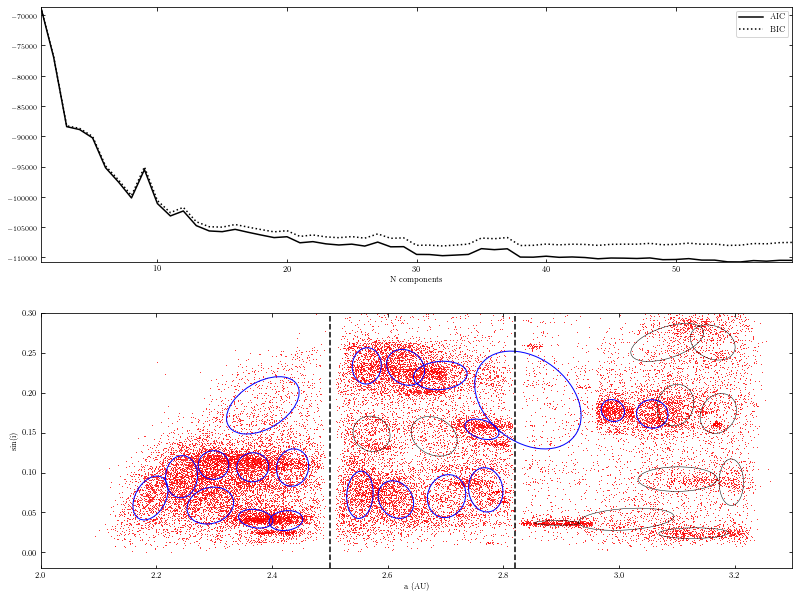

In [4]:
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(wspace=0.45, bottom=0.25, top=0.9, left=0.1, right=0.97)

# plot AIC/BIC
ax = fig.add_subplot(211)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, ':k', label='BIC')
ax.legend(loc=1)
ax.set_xlabel('N components')
plt.setp(ax.get_yticklabels(), fontsize=7)

# plot best configurations for AIC and BIC
ax = fig.add_subplot(212)

ax.scatter(a, sini, c='red', s=1, lw=0)

ind = np.argsort(gmm_best.weights_)[::-1]
for cnt, i in enumerate(ind[:N[i_best]]):
    mu = gmm_best.means_[i]
    C = gmm_best.covariances_[i]
    w = gmm_best.weights_[i]
    print(cnt, i, w)
    # the 20 most numerous clusters in blue
    if (cnt<20):
        draw_ellipse(mu, C, scales=[1.0], ax=ax, fc='none', lw=1.0, ec='blue')
    else:
        draw_ellipse(mu, C, scales=[1.0], ax=ax, fc='none', lw=0.5, ec='k')
 
ax.plot([2.5, 2.5], [-0.02, 0.3], '--k')
ax.plot([2.82, 2.82], [-0.02, 0.3], '--k')

ax.set_xlim(2.0, 3.3)
ax.set_ylim(-0.02, 0.3)

ax.set_xlabel('a (AU)')
ax.set_ylabel('sin(i)')

plt.show()

### What do you conclude about these GMM results?

In [5]:
#------------------------------------------------------------
# Compute the Minimum Spanning Tree clustering model
n_neighbors = 10
edge_cutoff = 0.9
cluster_cutoff = 10
model = HierarchicalClustering(n_neighbors=10, edge_cutoff=edge_cutoff,
                               min_cluster_size=cluster_cutoff)
model.fit(X)
print(" scale: %2g" % np.percentile(model.full_tree_.data,
                                        100 * edge_cutoff))
n_components = model.n_components_
labels = model.labels_
#------------------------------------------------------------
# Get the x, y coordinates of the beginning and end of each line segment
T_x, T_y = get_graph_segments(model.X_train_,
                              model.full_tree_)
T_trunc_x, T_trunc_y = get_graph_segments(model.X_train_,
                                          model.cluster_graph_)

 scale: 0.00319149


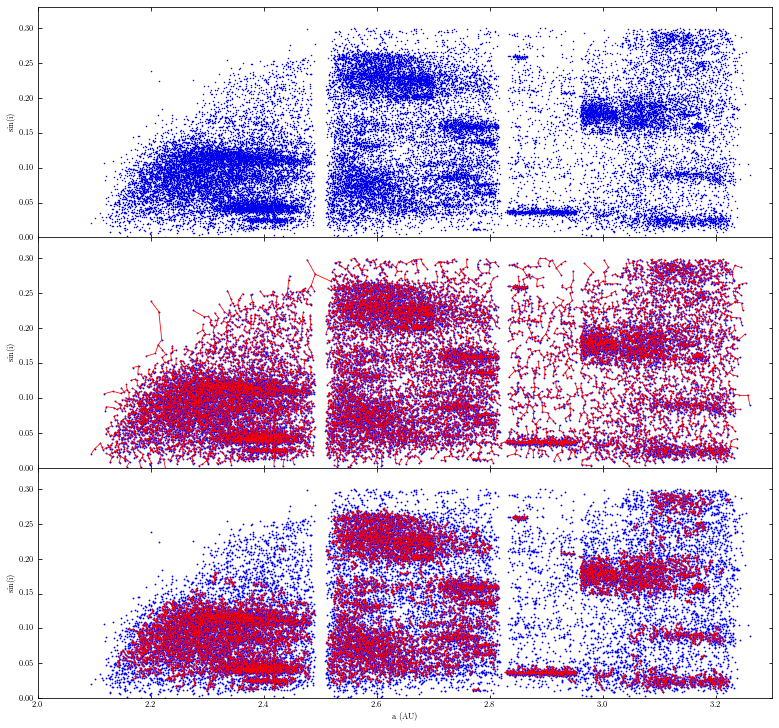

In [6]:
#------------------------------------------------------------
# Plot the results
xmin, xmax = (2.0, 3.3)
ymin, ymax = (0.0, 0.33)
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(311)
ax.scatter(X[:, 0], X[:, 1], s=1, lw=0.5, c='k')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('sin(i)')

ax = fig.add_subplot(312)
ax.scatter(X[:, 0], X[:, 1], s=1, lw=0.8, c='k')
ax.plot(T_x, T_y, c='red', lw=0.8)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('sin(i)')

ax = fig.add_subplot(313)
ax.scatter(X[:, 0], X[:, 1], s=1, lw=0.8, c='k')
ax.plot(T_trunc_x, T_trunc_y, c='red', lw=0.8)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('a (AU)')
ax.set_ylabel('sin(i)')

plt.show()

### What do you conclude about these results? How do they compare to GMM results? 

#### Note: we could now, on per object basis, compare the two classifications into background and clustered objects and somehow (depending on application) combine them into the final classification. 


## Problem 2: supervised classification of periodic variable stars in 7-D space of colors and lightcurve parameters


In [7]:
from astroML.datasets import fetch_LINEAR_geneva
from astroML.utils import split_samples
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [8]:
# Fetch data and extract the desired quantities
data = fetch_LINEAR_geneva()
# this is a 7-dimensional dataset
attributes = [('gi', 'logP', 'ug', 'iK', 'JK', 'amp', 'skew')]
ug = data['ug']
gi = data['gi']
logP = data['logP']
amp = data['Ampl'] 
skew = data['skew'] 
labels = data['LCtype']
# for historic reasons, type 3 is missing (and/or called 6)
labels[labels == 6] = 3

In [9]:
# enforce *nicer* color choices
symbcolor = np.full(np.size(labels), 'magenta')
symbcolor[labels == 1] = 'red'
symbcolor[labels == 2] = 'blue'
symbcolor[labels == 3] = 'black'
symbcolor[labels == 4] = 'magenta'
symbcolor[labels == 5] = 'green'

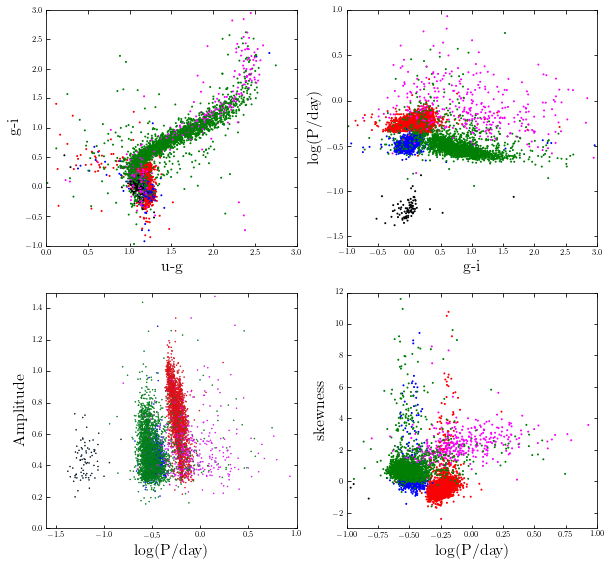

In [10]:
# Plot classes 
fig = plt.figure(figsize=(9, 9))
fig.subplots_adjust(wspace=0.2, hspace=0.2, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(221)
xmin, xmax = (0.0, 3.0)
ymin, ymax = (-1.0, 3.0)
ax.scatter(ug, gi, s=1, lw=1.0, ec=symbcolor)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('u-g', fontsize=16)
ax.set_ylabel('g-i', fontsize=16)

ax = fig.add_subplot(222)
xmin, xmax = (-1.0, 3.0)
ymin, ymax = (-1.6, 1.0)
ax.scatter(gi, logP, s=1, lw=1.0, ec=symbcolor)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('g-i', fontsize=16)
ax.set_ylabel('log(P/day)', fontsize=16)

ax = fig.add_subplot(223)
xmin, xmax = (-1.6, 1.0)
ymin, ymax = (0.0, 1.5)
ax.scatter(logP, amp, s=1, lw=0.5, ec=symbcolor)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('log(P/day)', fontsize=16)
ax.set_ylabel('Amplitude', fontsize=16)

ax = fig.add_subplot(224)
xmin, xmax = (-1.0, 1.0)
ymin, ymax = (-3, 12.0)
ax.scatter(logP, skew, s=1, lw=1.0, ec=symbcolor)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('log(P/day)', fontsize=16)
ax.set_ylabel('skewness', fontsize=16)

plt.show()

In [11]:
Ndim = 4
Ndata = labels.size
X = np.empty((Ndata, Ndim), dtype=float)
X[:Ndata, 0] = ug
X[:Ndata, 1] = gi
if (Ndim > 2):
    X[:Ndata, 2] = logP
    X[:Ndata, 3] = amp

y = np.zeros(Ndata, dtype=int)
y[:Ndata] = labels
# set ab and c type RR Lyrae to 1, other to 0
y[y == 2] = 1
y[y != 1] = 0

# split into training and test sets
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.9, 0.1], random_state=0) 

In [12]:
from sklearn.mixture import GaussianMixture

class GMMBayes(GaussianNB):
    """GaussianMixture Bayes Classifier

    This is a generalization to the Naive Bayes classifier: rather than
    modeling the distribution of each class with axis-aligned gaussians,
    GMMBayes models the distribution of each class with mixtures of
    gaussians.  This can lead to better classification in some cases.

    Parameters
    ----------
    n_components : int or list
        number of components to use in the GaussianMixture. If specified as
        a list, it must match the number of class labels. Default is 1.
    **kwargs : dict, optional
        other keywords are passed directly to GaussianMixture
    """

    def __init__(self, n_components=1, **kwargs):
        self.n_components = np.atleast_1d(n_components)
        self.kwargs = kwargs

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        n_samples, n_features = X.shape

        if n_samples != y.shape[0]:
            raise ValueError("X and y have incompatible shapes")

        self.classes_ = np.unique(y)
        self.classes_.sort()
        unique_y = self.classes_

        n_classes = unique_y.shape[0]

        if self.n_components.size not in (1, len(unique_y)):
            raise ValueError("n_components must be compatible with "
                             "the number of classes")

        self.gmms_ = [None for i in range(n_classes)]
        self.class_prior_ = np.zeros(n_classes)

        n_comp = np.zeros(len(self.classes_), dtype=int) + self.n_components

        for i, y_i in enumerate(unique_y):
            if n_comp[i] > X[y == y_i].shape[0]:
                warnstr = ("Expected n_samples >= n_components but got "
                           "n_samples={0}, n_components={1}, "
                           "n_components set to {0}.")
                warnings.warn(warnstr.format(X[y == y_i].shape[0], n_comp[i]))
                n_comp[i] = y_i
            self.gmms_[i] = GaussianMixture(n_comp[i], **self.kwargs).fit(X[y == y_i])
            self.class_prior_[i] = np.float(np.sum(y == y_i)) / n_samples

        return self

    def _joint_log_likelihood(self, X):

        X = np.asarray(np.atleast_2d(X))
        logprobs = np.array([g.score_samples(X) for g in self.gmms_]).T
        return logprobs + np.log(self.class_prior_)

In [13]:
# Compute fits for all the classifiers
def compute_results(*args):
    names = []
    probs = []

    for classifier, kwargs in args:
        print(classifier.__name__)
        model = classifier(**kwargs)
        # note that are using here the training subsample
        model.fit(X_train, y_train)
        # and here evaluating class using the testing subsample 
        y_prob = model.predict_proba(X_test)

        names.append(classifier.__name__)
        probs.append(y_prob[:, 1])

    return names, probs

LRclass_weight = dict([(i, np.sum(y_train == i)) for i in (0, 1)])

names, probs = compute_results((GaussianNB, {}),
                               (QDA, {}),
                               (LogisticRegression,
                                dict(class_weight=LRclass_weight)),
                               (KNeighborsClassifier,
                                dict(n_neighbors=10)),
                               (DecisionTreeClassifier,
                                dict(random_state=0, max_depth=12,
                                     criterion='entropy')),
                               (GMMBayes, dict(n_components=3, tol=1E-5,
                                               covariance_type='full')))

GaussianNB
QuadraticDiscriminantAnalysis
LogisticRegression
KNeighborsClassifier
DecisionTreeClassifier
GMMBayes


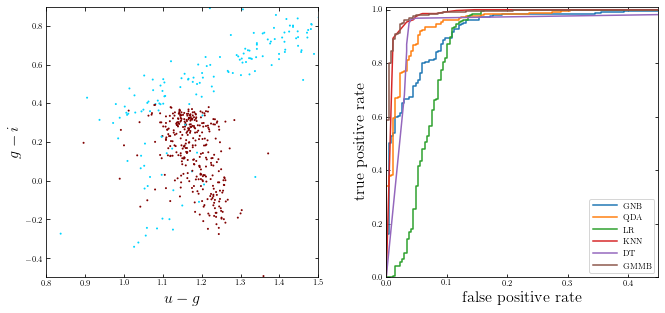

In [14]:
# Plot results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)

# First axis shows a projection of the data
ax1 = fig.add_subplot(121)
im = ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=4,
                 linewidths=0, edgecolors='none',
                 cmap=plt.cm.jet)
im.set_clim(-0.5, 1)
ax1.set_xlim(0.8, 1.5)
ax1.set_ylim(-0.5, 0.9)
ax1.set_xlabel('$u - g$', fontsize=16)
ax1.set_ylabel('$g - i$', fontsize=16)

labels = dict(GaussianNB='GNB',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              GMMBayes='GMMB',
              LogisticRegression='LR')

# Second axis shows the ROC curves
ax2 = fig.add_subplot(122)
for name, y_prob in zip(names, probs):
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    ax2.plot(fpr, tpr, label=labels[name])

ax2.legend(loc=4)
ax2.set_xlabel('false positive rate', fontsize=16)
ax2.set_ylabel('true positive rate', fontsize=16)
ax2.set_xlim(0, 0.45)
ax2.set_ylim(0.0, 1.01)
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))

plt.show()

### So, how well can we separate RR Lyrae from the rest of the sample? 

The answer of course depends where you are on the ROC curve. Since GMMB performs the best, let's look at its ROC curve: if you care about completeness (i.e. TPR), you pick FPR=0.1 and get TPR>0.99. On the other hand, if you care about a clean sample (low FPR), you pick the point with TPR=0.8 and FPR=0.01 (approximately). 